In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.text import *

import textwrap

/Users/adamschiller/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
PATH = Path('data/IAM_handwriting')
TMP_PATH = PATH/'tmp'

In [4]:
device = torch.device('cpu')#torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

# Helpers

In [5]:
def standardize_imgs(imgs, baseheight):
    resized_imgs = []
    for img in imgs:
        hpercent = (baseheight / float(img.size[1]))
        wsize = int((float(img.size[0]) * float(hpercent)))
        img = img.resize((wsize, baseheight), PIL.Image.ANTIALIAS)
        resized_imgs.append(img)
    return resized_imgs

In [6]:
def resize_max(im, size=512):
    "Resize an image so that the largest dimension is of specified size"
    r,c = im.size
    ratio = size/max(r,c)
    return im.resize((int(r*ratio), int(c*ratio)), Image.ANTIALIAS)

In [40]:
def square_max(im, top_left=False, size=None, ):
    '''
    Add whitespace to square an image by its largest dimension.
    Args:
        top_left: image is aligned with the top_left corner
        size: size of final squared image.  If left blank size = largest dimension
    '''
    
    r,c = im.size
    if size is not None and size > max(r,c):
        sz = size
    else:
        sz = max(r,c)
        
    new_im = Image.new('RGB', (sz, sz), color=(255,255,255))  # new white image
    
    # box logic
    if top_left:
        box = (0,0)
    else:
        if sz == r:
            box = (0,random.randint(0,sz-c)) 
        elif sz == c:
            box = (random.randint(0,sz-r),0)
        else:
            box = (random.randint(0,sz-r),random.randint(0,sz-c))
            
    new_im.paste(im, box=box)
    return new_im

In [8]:
def resize_dir(fn, src, targ=None):
    if targ is None: targ = src
    dirs = os.listdir(src)
    for item in tqdm(dirs):
        if os.path.isdir(src/item): continue     # skip if src dir
#         if os.path.isfile(targ/item): continue   # skip if file exists in targ dir
        im = Image.open(src/item)
        rsz = fn(im)
        rsz.save(targ/item)
        rsz.close()
        im.close()

In [9]:
def resize_to_square(src_dir, targ_dir, size):
    "Resize and square all images in src_dir and save in targ_dir"
    resize_dir(partial(resize_max, size=size), src_dir, targ_dir)
    resize_dir(square_max, targ_dir)

# Synthesize Data

## Lines

### DataFrame

In [10]:
df = pd.read_csv(f'{PATH}/ascii/lines.txt', names=['filename','result','value'], escapechar='\\',
                          delim_whitespace=True, skiprows=23, header=None, usecols=[0,1,8])
df['text'] = df.apply(lambda row: row.value.replace('|', ' '), axis=1)

# calculate character lengths
lgts = df.text.apply(len)  
df['text_len'] = lgts.astype('int32')

df.head()

,filename,result,value,text,text_len
0,a01-000u-00,ok,A|MOVE|to|stop|Mr.|Gaitskell|from,A MOVE to stop Mr. Gaitskell from,33
1,a01-000u-01,ok,nominating|any|more|Labour|life|Peers,nominating any more Labour life Peers,37
2,a01-000u-02,ok,is|to|be|made|at|a|meeting|of|Labour,is to be made at a meeting of Labour,36
3,a01-000u-03,err,MPs|tomorrow|.|Mr.|Michael|Foot|has,MPs tomorrow . Mr. Michael Foot has,35
4,a01-000u-04,ok,put|down|a|resolution|on|the|subject,put down a resolution on the subject,36


In [11]:
df = df[df.result != 'err']
df = df.loc[df['text_len'] > 20]
len(df)

10940

In [12]:
df.text_len.min(), df.text_len.median(), df.text_len.max()

(21, 43.0, 93)

### remove lines in paragraph validation set

In [13]:
# get paragraph val idxs
PG_CSV = PATH/'paragraph_chars.csv'
pg_csv = pd.read_csv(PG_CSV)
val_idxs = np.array(pg_csv.sample(frac=0.15, random_state=42).index)

In [14]:
names = pg_csv.filename[val_idxs].values
names = [name[:-4] for name in names]

In [15]:
fnames = df.filename.values
fnames = [name[:-3] for name in fnames]

In [16]:
st = set(names)
vals = [i for i, e in enumerate(fnames) if e in st]
len(vals), len(fnames)

(1638, 10940)

In [17]:
# remove vals from df
df.drop(df.index[vals], inplace=True)
len(df)

9302

### Create Data

In [18]:
def create_img(imgs, targ, sz=None, max_size=1000, pad=30):
    if sz==None: sz=(1, len(files))  #(w,h)
    w = 1 #sz[0]  
    h = sz  #sz[1]
        
    widths, heights = zip(*(i.size for i in imgs))
    
    median_height = int(np.median(heights))
    stzd_imgs = standardize_imgs(imgs, median_height)
    lines = [stzd_imgs[i:i + w] for i in range(0, len(stzd_imgs), w)]
    
    total_width = max([np.sum([word.size[0] for word in line]) for line in lines]) + (pad*(w+1))   
    total_height = (median_height * h) + (pad*(h+1)) #sum(heights)

    new_im = Image.new('RGB', (total_width, total_height), color=(255,255,255))

    y_offset = pad
    x_offset = pad
    
    for line in lines:
        x_offset = pad
        for word in line:
            new_im.paste(word, (x_offset,y_offset))
            x_offset += word.size[0] + pad
        y_offset += median_height + pad
    
    resize_max(new_im, max_size).save(targ)
#     new_im.save(synth_path/fname)

In [19]:
# number of words/image
def create_synth_data(num, num_lines, src_path, targ_path, max_size=None, offset=0):
    d={}
    for i in tqdm(range(num)):
        samp = df.sample(num_lines)
        files = list(map(lambda x: x+'.png', samp.filename.values))
        imgs  = [Image.open(src_path/f) for f in files]
        label = ' '.join(samp.text.values)

        fname = str(num_lines)+'_'+'{:04d}'.format(i+offset)+'.png'
        create_img(imgs, targ_path/fname, num_lines, max_size)
        [f.close() for f in imgs]
        d[fname] = label
    return d

In [20]:
src_path = PATH/'lines'
targ_path = PATH/'cat_lines'

num_lines = 3
d = create_synth_data(100, num_lines, src_path, targ_path)
len(d)

100%|██████████| 100/100 [00:08<00:00, 11.87it/s]


100

In [21]:
synth = pd.DataFrame({'filename': list(d.keys()), 'labels': list(d.values())})
synth.head()

,filename,labels
0,3_0000.png,had tin mugs filled with hot black coffee brou...
1,3_0001.png,at the speed recorder . It seemed almost incre...
2,3_0002.png,At last Derek got tired and left . letter . Sh...
3,3_0003.png,During that time a description of the girl was...
4,3_0004.png,The Foreign Ministry spokesman added him a gre...


In [166]:
# for i in tqdm([9,10,11,12]):
#     num_lines = i
#     d = create_synth_data(5000, num_lines, src_path, targ_path)
#     synth = pd.DataFrame({'filename': list(d.keys()), 'labels': list(d.values())})
    
#     joined_labels = list(synth.labels) #list(map(lambda x: ' '.join(x), labels))

#     stoi = collections.defaultdict(lambda: 2, {v:k for k,v in enumerate(itos)})
#     ids = np.array([np.array([stoi[letter] for letter in word] + [3]) for word in joined_labels])

#     # convert to strings (as labels)
#     str_ids = np.array([' '.join(str(l) for l in w) for w in ids]).reshape(-1,1)
#     synth['char_ids'] = str_ids
    
#     CSV = str(targ_path)+'_'+str(num_lines)+'.csv'
#     synth.to_csv(CSV, columns=['filename', 'char_ids'], index=False)

100%|██████████| 4/4 [1:17:10<00:00, 1157.69s/it]

## Words

### pd.read_csv

In [10]:
df = pd.read_csv(f'{PATH}/ascii/words.txt', names=['filename','result','value'], escapechar='\\', delim_whitespace=True, skiprows=23, header=None, usecols=[0,1,8])
df.rename(columns={'value': 'word'}, inplace=True)
len(df)

75597

In [11]:
# remove errors
df = df[df.result != 'err']
len(df)

64750

In [12]:
# calculate character lengths
lgts = df.word.apply(len)  
df['char_len'] = lgts.astype('int32')

In [13]:
# lots of errors from pd.read_csv
# only keep rows w/ word length < 20
df = df[df.char_len < 20]

In [14]:
df = df.loc[df['char_len'] > 3]

In [15]:
df.head()

,filename,result,word,char_len
0,a01-000u-00-05,ok,Gaitskell,9
1,a01-000u-00-06,ok,from,4
2,a01-000u-01-00,ok,nominating,10
4,a01-000u-01-02,ok,more,4
5,a01-000u-01-03,ok,Labour,6


### manually created df

In [78]:
maxTextLen = 32
samples = []
chars = set()

f=open(f'{PATH}/ascii/words.txt')
for line in f:
    # ignore comment line
    if not line or line[0]=='#':
        continue

    lineSplit = line.strip().split(' ')
    assert len(lineSplit) >= 9

    fileName = lineSplit[0]

    # GT text are columns starting at 9
    gtText = ''.join(lineSplit[8:])[:maxTextLen]
    char_len = len(gtText)
    chars = chars.union(set(list(gtText)))

    # put sample into list
    samples.append([fileName, gtText, char_len])
    
samples = np.stack(samples)
df = pd.DataFrame(samples, columns=['filename', 'word', 'char_len'], )
del samples

In [79]:
df['char_len'] = df.char_len.astype('int32')
df = df.loc[df['char_len'] > 3]
df = df.loc[df['char_len'] < 20]
df.head()

,filename,word,char_len
1,a01-000u-00-01,MOVE,4
3,a01-000u-00-03,stop,4
5,a01-000u-00-05,Gaitskell,9
6,a01-000u-00-06,from,4
7,a01-000u-01-00,nominating,10


### specify number of words per line

In [46]:
def create_img(src_path, targ_path, files, fname, sz=None, pad=30):
    if sz==None: sz=(1, len(files))  #(w,h)
    w = sz[1]
    h = sz[0]
        
    imgs = [ PIL.Image.open(src_path/f) for f in files ]
    widths, heights = zip(*(i.size for i in imgs))
    
    median_height = int(np.median(heights))
    stzd_imgs = standardize_imgs(imgs, median_height)
    lines = [stzd_imgs[i:i + w] for i in range(0, len(stzd_imgs), w)]
    
    total_width = max([np.sum([word.size[0] for word in line]) for line in lines]) + (pad*(w+1))   
    total_height = (median_height * h) + (pad*(h+1)) #sum(heights)

    new_im = Image.new('RGB', (total_width, total_height), color=(255,255,255))

    y_offset = pad
    x_offset = pad
    
    for line in lines:
        x_offset = pad
        for word in line:
            new_im.paste(word, (x_offset,y_offset))
            x_offset += word.size[0] + pad
        y_offset += median_height + pad
        
    new_im.save(targ_path/fname)

#### Create Data

In [73]:
src_path = PATH/'words'
synth_path = PATH/'mixed_synth_words'
!rm -rf {synth_path}

os.makedirs(synth_path, exist_ok=True)

In [74]:
# number of words/image
def create_synth_data(src_path, targ_path, num, sz, offset=0, randomize=False):
    d={}
    for i in tqdm(range(num)):
        if randomize:
            r = random.randint(1,sz[0])
            c = random.randint(1,sz[1])
        else:
            r,c = sz
            
        num_samp = np.product((r,c))
        res = df.sample(num_samp)
        files = list(map(lambda x: x+'.png', res.filename.values))
        
        # split into rows with \n
        label = '\n'.join([' '.join(row) for row in np.array_split(res.word.values, r)])
#         label = ' '.join(res.word.values)
        
        fname = '{:04d}'.format(i+offset)+'.png'
        create_img(src_path, targ_path, files, fname, (r,c))
        d[fname] = label
    return d

In [75]:
d = create_synth_data(src_path, synth_path, 1000, (3,3), randomize=True)
len(d)

100%|██████████| 1000/1000 [00:46<00:00, 21.50it/s]


1000

In [76]:
synth = pd.DataFrame({'filename': list(d.keys()), 'labels': list(d.values())})
synth.head()

,filename,labels
0,0000.png,Chinese being very\nseventeen foreign perhaps\...
1,0001.png,that 1959
2,0002.png,while brain-children CONCURRENCE\nwith called ...
3,0003.png,their what
4,0004.png,some- this activists


In [52]:
# resize_dir(partial(resize_max, size=512), src_path)
resize_dir(partial(square_max, size=1000), synth_path)

100%|██████████| 1000/1000 [01:42<00:00,  9.80it/s]


### specify size of image

In [45]:
def create_img(sz, fname, pad=30, median_height=None):
    # TODO: randomize padding
    new_im = Image.new('RGB', (sz,sz), color=(255,255,255))
    
    res   = df.sample(50)
    files = list(map(lambda x: x+'.png', res.filename.values))
    lbls  = res.word.values.tolist()
    imgs  = [ PIL.Image.open(PATH/'words'/f) for f in files ]
    
    if median_height is None:
        w, h  = zip(*(i.size for i in imgs))
        # standardize heights and sort longest to shortest words
        median_height = int(np.median(h))        # TODO: randomize this between mean/std
        
    stzd_imgs = standardize_imgs(imgs, median_height)
    
    #loop through standardized images and find the next image which satisfies the condition
    labels = []
    y_offset = pad
    while y_offset+median_height+pad < sz:        
        x_offset = pad
        
        gen = (i for i,x in enumerate(stzd_imgs) if x.size[0]+x_offset+pad <= sz)
        for idx in gen:
            word = stzd_imgs.pop(idx)            
            labels.append(lbls.pop(idx))
            new_im.paste(word, (x_offset,y_offset))
            x_offset += word.size[0] + pad
        y_offset += median_height+pad

    new_im.save(synth_path/fname)
    return ' '.join(labels)

#### Create Data

In [44]:
# for testing
synth_path = PATH/'large_synth_words'
!rm -rf {synth_path}

os.makedirs(synth_path, exist_ok=True)

In [46]:
# size of image
def create_synth_data(qty, sz, fname_offset=0):
    d={}
    for i in range(qty):
        fname = '{:04d}'.format(i+fname_offset)+'.png'
        p = random.randint(10,20)
        h = random.randint(25,35)
        d[fname] = create_img(sz, fname, pad=p, median_height=h)
    return d

d = create_synth_data(10, 512)
len(d)

# ~25min to create 5000 1000x1000 images

10

In [47]:
synth = pd.DataFrame({'filename': list(d.keys()), 'labels': list(d.values())})
synth.head()

,filename,labels
0,0000.png,away truth Vesuvius British enough Stone neigh...
1,0001.png,tray said blue near fires factor households th...
2,0002.png,weapon personal really together minds their la...
3,0003.png,tendon hypnotised Superintendent hopeless ment...
4,0004.png,cured sings burden method from gladly imaginat...


## Verify

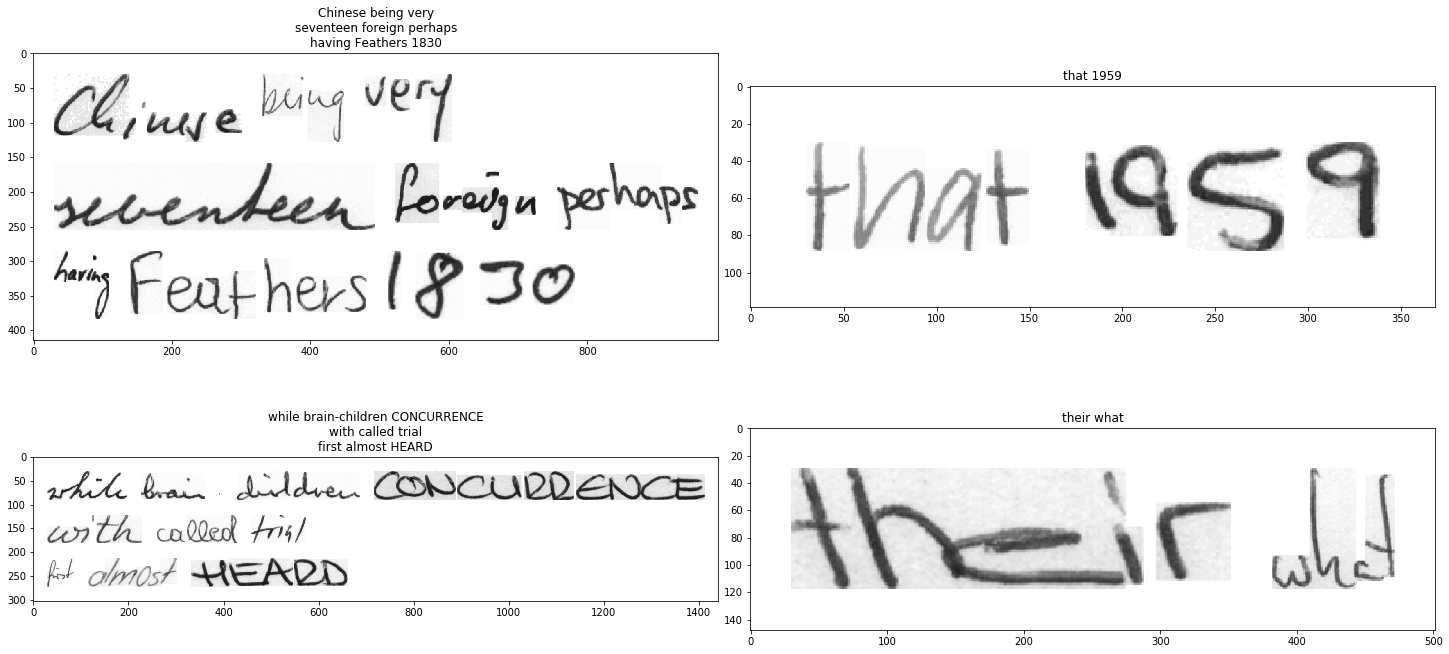

In [78]:
fig, axes = plt.subplots(2,2, figsize=(20, 10))
for i,ax in enumerate(axes.flat):
    row = synth.iloc[i]
    im = Image.open(synth_path/row.filename)
    ax.imshow(im)
    label = row.labels
#     label = '\n'.join(textwrap.wrap(row.labels, 70))
    ax.set_title(label)
    
plt.tight_layout(pad=0.2)

## Numericalize characters

In [89]:
# same as used in single word / multi-word
itos = pickle.load(open(TMP_PATH/'char_itos.pkl', 'rb'))
len(itos)

83

In [90]:
joined_labels = list(synth.labels) #list(map(lambda x: ' '.join(x), labels))

stoi = collections.defaultdict(lambda: 82, {v:k for k,v in enumerate(itos)})
ids = np.array([np.array([stoi[letter] for letter in word] + [3]) for word in joined_labels])

# convert to strings (as labels)
str_ids = np.array([' '.join(str(l) for l in w) for w in ids]).reshape(-1,1)

In [91]:
synth['char_ids'] = str_ids
synth.head()

,filename,labels,char_ids
0,0000.png,Chinese being very\nseventeen foreign perhaps\...,32 63 64 69 60 74 60 1 57 60 64 69 62 1 77 60 ...
1,0001.png,that 1959,75 63 56 75 1 18 26 22 26 3
2,0002.png,while brain-children CONCURRENCE\nwith called ...,78 63 64 67 60 1 57 73 56 64 69 14 58 63 64 67...
3,0003.png,their what,75 63 60 64 73 1 78 63 56 75 3
4,0004.png,some- this activists,74 70 68 60 14 1 75 63 64 74 1 56 58 75 64 77 ...


In [94]:
CSV = str(synth_path) + '.csv'
synth.to_csv(CSV, columns=['filename', 'char_ids'], index=False)

In [165]:
# multi-line
CSV = str(targ_path)+'_'+str(num_lines)+'.csv'
synth.to_csv(CSV, columns=['filename', 'char_ids'], index=False)

### Concatenate CSVs

In [167]:
a = pd.read_csv(PATH/'cat_lines_3.csv')
b = pd.read_csv(PATH/'cat_lines_4.csv')
c = pd.read_csv(PATH/'cat_lines_5.csv')

In [168]:
new = pd.concat([a,b,c], ignore_index=True)
len(new)

15000

In [169]:
new.to_csv(PATH/'cat_lines_345.csv', index=False)

### Add to existing CSV

In [50]:
CSV = PATH/'large_synth_words_10000.csv'
csv = pd.read_csv(CSV)
len(csv)

10000

In [51]:
# CSV = PATH/'synth_words_50000.csv'
CSV = PATH/'large_synth_words_50000.csv'

new = pd.concat([csv, synth[['filename', 'char_ids']]], ignore_index=True)
new.to_csv(CSV, columns=['filename', 'char_ids'], index=False)

In [52]:
len(new)

50000

## Numericalize words

In [53]:
itos = pickle.load(open(TMP_PATH/'synth_word_itos.pkl', 'rb'))
len(itos)

5902

In [54]:
joined_labels = list(synth.labels)

stoi = collections.defaultdict(lambda: 2, {v:k for k,v in enumerate(itos)})
ids = np.array([np.array([stoi[word] for word in line.split(' ')]+[3]) for line in joined_labels])

# convert to strings (as labels)
str_ids = np.array([' '.join(str(l) for l in w) for w in ids]).reshape(-1,1)

In [55]:
synth['word_ids'] = str_ids
synth.head()

,filename,labels,char_ids,word_ids
0,10000.png,with carriage verso that content circum- could...,78 64 75 63 1 58 56 73 73 64 56 62 60 1 77 60 ...,5 3542 2 4 1051 2 27 29 2 2 29 1314 66 2 372 3...
1,10001.png,"Referring West 3,000 England cruel strained de...",47 60 61 60 73 73 64 69 62 1 52 60 74 75 1 20 ...,2 156 4251 219 4271 2 2 572 247 483 2495 2429 ...
2,10002.png,tary were made extremes advantage good Greppes...,75 56 73 80 1 78 60 73 60 1 68 56 59 60 1 60 7...,2 11 36 2 1840 53 2 75 902 757 40 16 3061 4 32...
3,10003.png,that make such east brother-in-law forty with ...,75 63 56 75 1 68 56 66 60 1 74 76 58 63 1 60 5...,4 76 74 2 570 1583 5 17 2 373 5 553 277 183 25...
4,10004.png,made late landing whose bone-jarring that Larr...,68 56 59 60 1 67 56 75 60 1 67 56 69 59 64 69 ...,36 326 3833 364 2 4 5856 13 14 250 84 2419 12 ...


### Add to existing CSV

In [56]:
CSV = PATH/'large_synth_word_ids_10000.csv'
csv = pd.read_csv(CSV)

In [57]:
# CSV = PATH/'synth_words_50000.csv'
CSV = PATH/'large_synth_word_ids_50000.csv'

new = pd.concat([csv, synth[['filename', 'word_ids']]], ignore_index=True)
new.to_csv(CSV, columns=['filename', 'word_ids'], index=False)

In [58]:
len(new)

50000

### Modify csv/itos to match previous versions

In [63]:
itos_old = pickle.load(open(TMP_PATH/'synth_word_itos.pkl', 'rb'))

# same as used in single word / multi-word
itos = pickle.load(open(TMP_PATH/'char_itos.pkl', 'rb'))

In [64]:
res = [''.join([itos_old[int(c)] for c in line.split(' ')]) for line in csv.char_ids]
csv['words'] = res
csv.head()

,filename,char_ids,words
0,0000.png,66 55 57 59 13 1 58 59 55 74 62 1 60 69 75 72 ...,lace- death four warily considerably without
1,0001.png,60 69 69 58 1 74 77 59 68 74 63 59 74 62 1 51 ...,food twentieth Western been proved Rhodesia
2,0002.png,74 55 73 65 1 57 62 69 63 57 59 1 56 59 63 68 ...,task choice being longshore which childless
3,0003.png,55 58 76 63 73 59 72 73 1 74 62 55 74 1 35 33 ...,advisers that GENERAL were false example
4,0004.png,59 73 70 59 57 63 55 66 66 79 1 48 62 55 74 1 ...,especially That step rolls know been


In [65]:
joined_labels = list(csv.words) #list(map(lambda x: ' '.join(x), labels))

stoi = collections.defaultdict(lambda: 2, {v:k for k,v in enumerate(itos)})
ids = np.array([np.array([stoi[letter] for letter in word]+[3]) for word in joined_labels])

In [66]:
# convert to strings (as labels)
str_ids = np.array([' '.join(str(l) for l in w) for w in ids]).reshape(-1,1)

In [72]:
csv['char_ids'] = str_ids
csv = csv[['filename', 'char_ids']]
csv.head()

,filename,char_ids
0,0000.png,67 56 58 60 14 1 59 60 56 75 63 1 61 70 76 73 ...
1,0001.png,61 70 70 59 1 75 78 60 69 75 64 60 75 63 1 52 ...
2,0002.png,75 56 74 66 1 58 63 70 64 58 60 1 57 60 64 69 ...
3,0003.png,56 59 77 64 74 60 73 74 1 75 63 56 75 1 36 34 ...
4,0004.png,60 74 71 60 58 64 56 67 67 80 1 49 63 56 75 1 ...


### Verify

In [31]:
def label_text(pred):
#     ints = to_np(pred).astype(int)
#     ints = np.trim_zeros(ints)   # remove padding (0)
    return ''.join([itos[int(i)] for i in pred])

ValueError: left cannot be >= right

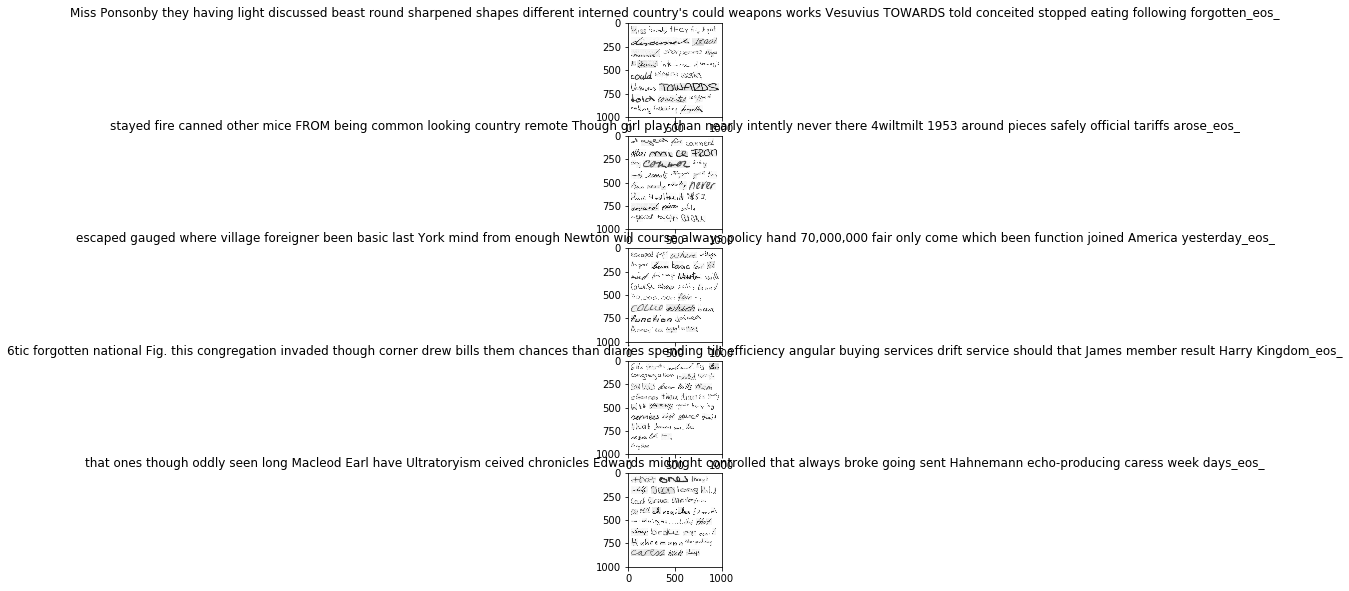

In [34]:
fig, axes = plt.subplots(5,1, figsize=(10, 10))
for i,ax in enumerate(axes.flat):
    row = synth.iloc[i]
    im = Image.open(synth_path/row.filename)
    ax.imshow(im)
    ax.set_title(label_text(row.char_ids.split(' ')))
    
plt.tight_layout(pad=0.2)

# Batch Resize

In [33]:
targ_path = PATH/'test_resize'
os.makedirs(targ_path, exist_ok=True)

In [32]:
src_path = PATH/'cat_lines'
targ_path = PATH/'resized_cat_lines'
os.makedirs(targ_path, exist_ok=True)

In [65]:
resize_to_square(src_path, targ_path, 1000)

100%|██████████| 100/100 [00:10<00:00,  9.92it/s]


In [41]:
# resize_dir(partial(resize_max, size=512), src_path)
resize_dir(partial(square_max, size=1000), synth_path)

100%|██████████| 10/10 [00:01<00:00,  7.93it/s]
